In [1]:
import torch
import numpy as np
import os
os.chdir('..')

import torch_converter as tc
import instance_generator as ig
from torch_geometric.loader import DataLoader
from gnn_library.util import train, save, load
from util import NumpyDataset, Dataset
from evaluate import evaluate_model, pp_output
import evaluate as ev
from gnn_library.OBM_greedy import OBM_Greedy
#import evaluate as ev

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print("PyTorch has version {}".format(torch.__version__))
print('Using device:', device)

PyTorch has version 2.0.0+cu117
Using device: cuda:2


In [3]:
GNN1, args1 = load('GNN1', device)
GNN2, args2 = load('GNN2', device)
# GNN3, args3 = load('GNN3', device)
GREEDY = OBM_Greedy()

### I. Meta GNN training/evaluation

In [17]:
args = {
    'processor':         'TEST',
    'head':              'meta',
    'num_layers':        2,
    'num_mlp_layers':    2,
    'aggr':              'max',
    'batch_size':        6,
    'node_feature_dim':  4,
    'edge_feature_dim':  1,
    'graph_feature_dim': 2,
    'hidden_dim':        64,
    'output_dim':        2,
    'dropout':           0.25,
    'epochs':            25,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.0001,
    'device':            device
}

train_num = 25; test_num = 5

er_config = {
    'graph_type': 'ER',
    'p': 1,
    'weighted': True
}
ba_config = {
    'graph_type': 'BA',
    'ba_param': 4,
    'weighted': False
}
geom_config = {
    'graph_type': 'GEOM',
    'threshold': 0.2,
    'scaling': 1 / np.sqrt(2)
}

rng = np.random.default_rng()

train_instances = [
    *ig.sample_instances(6, 10, train_num, rng, **er_config),
    *ig.sample_instances(6, 10, train_num, rng, **ba_config),
    *ig.sample_instances(6, 10, train_num, rng, **geom_config),
    *ig.sample_instances(8, 8, train_num, rng, **er_config),
    *ig.sample_instances(8, 8, train_num, rng, **ba_config),
    *ig.sample_instances(8, 8, train_num, rng, **geom_config),
    *ig.sample_instances(10, 6, train_num, rng, **er_config),
    *ig.sample_instances(10, 6, train_num, rng, **ba_config),
    *ig.sample_instances(10, 6, train_num, rng, **geom_config)
]


test_instances = [
    *ig.sample_instances(6, 10, test_num, rng, **er_config),
    *ig.sample_instances(6, 10, test_num, rng, **ba_config),
    *ig.sample_instances(6, 10, test_num, rng, **geom_config),
    *ig.sample_instances(8, 8, test_num, rng, **er_config),
    *ig.sample_instances(8, 8, test_num, rng, **ba_config),
    *ig.sample_instances(8, 8, test_num, rng, **geom_config),
    *ig.sample_instances(10, 6, test_num, rng, **er_config),
    *ig.sample_instances(10, 6, test_num, rng, **ba_config),
    *ig.sample_instances(10, 6, test_num, rng, **geom_config)
]

train_data = Dataset(
    tc._instances_to_train_samples(
        instances=train_instances,
        head=args['head'],
        meta_model_type='gnn',
        base_models=[GNN1, GNN2]
    )
)

test_data = Dataset(
    tc._instances_to_train_samples(
        instances=test_instances,
        head=args['head'],
        meta_model_type='gnn',
        base_models=[GNN1, GNN2]
    )
)

train_loader = DataLoader(
    train_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    test_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

In [4]:
args = {
    'processor':         'TEST2',
    'head':              'meta',
    'num_layers':        4,
    'num_lp_layers':     2,
    'aggr':              'max',
    'batch_size':        6,
    'node_feature_dim':  6,
    'edge_feature_dim':  1,
    'graph_feature_dim': 2,
    'hidden_dim':        4,
    'output_dim':        2,
    'dropout':           0,
    'epochs':            50,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.001,
    'device':            device
}

In [19]:
sum = torch.zeros(2)
for data in train_data:
    sum += data.hint
print(sum)

tensor([145., 129.])


In [20]:
_, _, META_GNN, _ = train(train_loader, test_loader, args)

Training:   0%|          | 0/50 [00:00<?, ?Epochs/s]

0.7113666251628068


Training:   2%|▏         | 1/50 [00:03<02:32,  3.11s/Epochs]

TEST ACCURACY: 0.5522388219833374
TEST LOSS: 0.6817859411239624


Training:   4%|▍         | 2/50 [00:04<01:48,  2.26s/Epochs]

0.7103076242182377
0.7034545353729359


Training:   6%|▌         | 3/50 [00:07<01:52,  2.40s/Epochs]

TEST ACCURACY: 0.5522388219833374
TEST LOSS: 0.6773368120193481


Training:   8%|▊         | 4/50 [00:09<01:39,  2.15s/Epochs]

0.6865031484269748
0.6732044563676319


Training:  10%|█         | 5/50 [00:11<01:38,  2.20s/Epochs]

TEST ACCURACY: 0.7164179086685181
TEST LOSS: 0.6700090765953064


Training:  12%|█▏        | 6/50 [00:13<01:38,  2.23s/Epochs]

0.6641459800031063
0.6574860615451841


Training:  14%|█▍        | 7/50 [00:16<01:38,  2.29s/Epochs]

TEST ACCURACY: 0.6716417670249939
TEST LOSS: 0.6670339703559875


Training:  16%|█▌        | 8/50 [00:17<01:30,  2.15s/Epochs]

0.6513519421981199
0.6459689914745136


Training:  18%|█▊        | 9/50 [00:20<01:29,  2.18s/Epochs]

TEST ACCURACY: 0.7164179086685181
TEST LOSS: 0.6477149128913879


Training:  20%|██        | 10/50 [00:21<01:21,  2.05s/Epochs]

0.6362961082562913
0.632262293439712


Training:  22%|██▏       | 11/50 [00:24<01:27,  2.25s/Epochs]

TEST ACCURACY: 0.7611939907073975
TEST LOSS: 0.6373624801635742


Training:  24%|██▍       | 12/50 [00:26<01:19,  2.10s/Epochs]

0.625468484241597
0.6189506884909024


Training:  26%|██▌       | 13/50 [00:28<01:21,  2.19s/Epochs]

TEST ACCURACY: 0.7761194109916687
TEST LOSS: 0.6243304014205933


Training:  28%|██▊       | 14/50 [00:30<01:14,  2.07s/Epochs]

0.6118568438683113
0.6064480830283061


Training:  30%|███       | 15/50 [00:33<01:17,  2.22s/Epochs]

TEST ACCURACY: 0.746268630027771
TEST LOSS: 0.619926929473877


Training:  32%|███▏      | 16/50 [00:34<01:10,  2.06s/Epochs]

0.6084878201032207
0.5964096406080427


Training:  34%|███▍      | 17/50 [00:37<01:10,  2.12s/Epochs]

TEST ACCURACY: 0.7761194109916687
TEST LOSS: 0.6091129183769226


Training:  36%|███▌      | 18/50 [00:38<01:03,  2.00s/Epochs]

0.5905941609483566
0.5849064210035505


Training:  38%|███▊      | 19/50 [00:41<01:04,  2.09s/Epochs]

TEST ACCURACY: 0.7611939907073975
TEST LOSS: 0.6062901616096497


Training:  40%|████      | 20/50 [00:42<00:59,  1.99s/Epochs]

0.5817864415419363
0.5748971820312695


Training:  42%|████▏     | 21/50 [00:45<01:04,  2.21s/Epochs]

TEST ACCURACY: 0.7910447716712952
TEST LOSS: 0.589599072933197


Training:  44%|████▍     | 22/50 [00:47<00:57,  2.05s/Epochs]

0.5788236277816939
0.5817897524276789


Training:  46%|████▌     | 23/50 [00:49<00:56,  2.09s/Epochs]

TEST ACCURACY: 0.7910447716712952
TEST LOSS: 0.5815468430519104


Training:  48%|████▊     | 24/50 [00:51<00:52,  2.00s/Epochs]

0.5834958100840993
0.5757668596984696


Training:  50%|█████     | 25/50 [00:53<00:51,  2.06s/Epochs]

TEST ACCURACY: 0.7910447716712952
TEST LOSS: 0.5863474607467651


Training:  52%|█████▏    | 26/50 [00:55<00:47,  1.98s/Epochs]

0.5699480661075481
0.5685427774042979


Training:  54%|█████▍    | 27/50 [00:57<00:47,  2.06s/Epochs]

TEST ACCURACY: 0.7910447716712952
TEST LOSS: 0.5797392725944519


Training:  56%|█████▌    | 28/50 [00:59<00:42,  1.95s/Epochs]

0.5652696022587101
0.5633009343686766


Training:  58%|█████▊    | 29/50 [01:01<00:44,  2.14s/Epochs]

TEST ACCURACY: 0.8059701323509216
TEST LOSS: 0.5765560865402222


Training:  60%|██████    | 30/50 [01:03<00:40,  2.02s/Epochs]

0.5613508013478161
0.5596858919972051


Training:  62%|██████▏   | 31/50 [01:05<00:39,  2.09s/Epochs]

TEST ACCURACY: 0.8059701323509216
TEST LOSS: 0.5699300765991211


Training:  64%|██████▍   | 32/50 [01:07<00:35,  1.95s/Epochs]

0.5581327285209712
0.5572958244894543


Training:  66%|██████▌   | 33/50 [01:09<00:34,  2.03s/Epochs]

TEST ACCURACY: 0.8059701323509216
TEST LOSS: 0.5686379671096802


Training:  68%|██████▊   | 34/50 [01:11<00:30,  1.94s/Epochs]

0.5563840696411412
0.5561860745405629


Training:  70%|███████   | 35/50 [01:13<00:30,  2.05s/Epochs]

TEST ACCURACY: 0.8059701323509216
TEST LOSS: 0.5620054602622986


Training:  72%|███████▏  | 36/50 [01:15<00:27,  1.95s/Epochs]

0.5568724888084579
0.5536415067902447


Training:  74%|███████▍  | 37/50 [01:17<00:26,  2.03s/Epochs]

TEST ACCURACY: 0.8059701323509216
TEST LOSS: 0.5611840486526489


Training:  76%|███████▌  | 38/50 [01:19<00:24,  2.00s/Epochs]

0.5513948104242339
0.550981277531951


Training:  78%|███████▊  | 39/50 [01:21<00:22,  2.08s/Epochs]

TEST ACCURACY: 0.8059701323509216
TEST LOSS: 0.557553768157959


Training:  80%|████████  | 40/50 [01:23<00:19,  1.98s/Epochs]

0.5487376725586661
0.5492253183883472


Training:  82%|████████▏ | 41/50 [01:26<00:20,  2.22s/Epochs]

TEST ACCURACY: 0.8059701323509216
TEST LOSS: 0.5667229890823364


Training:  84%|████████▍ | 42/50 [01:28<00:16,  2.07s/Epochs]

0.5480030068080791
0.5467826902431293


Training:  86%|████████▌ | 43/50 [01:30<00:15,  2.23s/Epochs]

TEST ACCURACY: 0.8059701323509216
TEST LOSS: 0.5565277338027954


Training:  88%|████████▊ | 44/50 [01:32<00:12,  2.10s/Epochs]

0.5463843578404753
0.5455934538023315


Training:  90%|█████████ | 45/50 [01:34<00:11,  2.20s/Epochs]

TEST ACCURACY: 0.8059701323509216
TEST LOSS: 0.5545482635498047


Training:  92%|█████████▏| 46/50 [01:36<00:08,  2.09s/Epochs]

0.5466663017325157
0.5461296996060949


Training:  94%|█████████▍| 47/50 [01:39<00:06,  2.22s/Epochs]

TEST ACCURACY: 0.8059701323509216
TEST LOSS: 0.5565930604934692


Training:  96%|█████████▌| 48/50 [01:41<00:04,  2.11s/Epochs]

0.5447660340879955
0.5416888633783716


Training:  98%|█████████▊| 49/50 [01:43<00:02,  2.17s/Epochs]

TEST ACCURACY: 0.7761194109916687
TEST LOSS: 0.5611750483512878


Training: 100%|██████████| 50/50 [01:45<00:00,  2.10s/Epochs]

0.5389533232163338


In [21]:
save(META_GNN, args, 'META_TEST')

In [4]:
META_GNN, args = load('META_GNN', device)

In [ ]:
args = {
    'processor':         'TEST2',
    'head':              'meta',
    'num_layers':        4,
    'num_mlp_layers':    2,
    'aggr':              'max',
    'batch_size':        6,
    'node_feature_dim':  6,
    'edge_feature_dim':  1,
    'graph_feature_dim': 2,
    'hidden_dim':        8,
    'output_dim':        2,
    'head_mlp_dim':      8,
    'dropout':           0,
    'epochs':            200,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.0005,
    'device':            device
}

train_num = 100; test_num = 20

er_config = {
    'graph_type': 'ER',
    'p': 1,
    'weighted': True
}
ba_config = {
    'graph_type': 'BA',
    'ba_param': 4,
    'weighted': False
}
geom_config = {
    'graph_type': 'GEOM',
    'threshold': 0.2,
    'scaling': 1 / np.sqrt(2)
}


rng = np.random.default_rng()

train_instances = [
    *ig.sample_instances(6, 10, train_num, rng, **er_config),
    *ig.sample_instances(6, 10, train_num, rng, **ba_config),
    *ig.sample_instances(6, 10, train_num, rng, **geom_config),
    *ig.sample_instances(8, 8, train_num, rng, **er_config),
    *ig.sample_instances(8, 8, train_num, rng, **ba_config),
    *ig.sample_instances(8, 8, 4*train_num, rng, **geom_config),
    *ig.sample_instances(10, 6, train_num, rng, **er_config),
    *ig.sample_instances(10, 6, train_num, rng, **ba_config),
    *ig.sample_instances(10, 6, train_num, rng, **geom_config)
]


test_instances = [
    *ig.sample_instances(6, 10, test_num, rng, **er_config),
    *ig.sample_instances(6, 10, test_num, rng, **ba_config),
    *ig.sample_instances(6, 10, test_num, rng, **geom_config),
    *ig.sample_instances(8, 8, test_num, rng, **er_config),
    *ig.sample_instances(8, 8, test_num, rng, **ba_config),
    *ig.sample_instances(8, 8, 4*test_num, rng, **geom_config),
    *ig.sample_instances(10, 6, test_num, rng, **er_config),
    *ig.sample_instances(10, 6, test_num, rng, **ba_config),
    *ig.sample_instances(10, 6, test_num, rng, **geom_config)
]


train_data = Dataset(
    tc._instances_to_train_samples(
        instances=train_instances,
        head=args['head'],
        meta_model_type='gnn',
        base_models=[GNN1, GNN2]
    )
)

test_data = Dataset(
    tc._instances_to_train_samples(
        instances=test_instances,
        head=args['head'],
        meta_model_type='gnn',
        base_models=[GNN1, GNN2]
    )
)

In [ ]:
train_loader = DataLoader(
    train_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    test_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

In [ ]:
_, _, META_GNN, _ = train(train_loader, test_loader, args)

In [ ]:
save(META_GNN, args, 'META_GNN')

In [5]:
er_config = {
    'graph_type': 'ER',
    'p': 1,
    'weighted': True
}
ba_config = {
    'graph_type': 'BA',
    'ba_param': 4,
    'weighted': False
}
geom_config = {
    'graph_type': 'GEOM',
    'threshold': 0.2,
    'scaling': 1 / np.sqrt(2)
}

In [17]:
seed = np.random.randint(0, 500000)
(m, n) = (24, 16)
config = er_config

rng = np.random.default_rng(seed)
eval_instances = ig.sample_instances(m, n, 10, rng, **config)

rng = np.random.default_rng(seed)
ratios1 = ev.evaluate_model(
    meta_model=META_GNN,
    meta_model_type='gnn',
    base_models=[GNN1, GNN2],
    instances=eval_instances,
    batch_size=500,
    rng=rng,
    num_realizations=10
)

pp_output(ratios1, _, show_log=False)
print()
print()

rng = np.random.default_rng(seed)

ratios2 = ev.evaluate_model(
    meta_model=None,
    meta_model_type=None,
    base_models=[GNN1],
    instances=eval_instances,
    batch_size=500,
    rng=rng,
    num_realizations=10
)

pp_output(ratios2, _, show_log=False)

print()
print()

rng = np.random.default_rng(seed)

ratios = ev.evaluate_model(
    meta_model=None,
    meta_model_type=None,
    base_models=[GNN2],
    instances=eval_instances,
    batch_size=500,
    rng=rng,
    num_realizations=10
)

pp_output(ratios, _, show_log=False)

-- Competitive ratios --
GNN: 0.9581
Greedy: 0.9095


-- Competitive ratios --
GNN: 0.9543
Greedy: 0.9095


-- Competitive ratios --
GNN: 0.9468
Greedy: 0.9095


In [ ]:
print(np.mean(ratios1[0] >= np.max(np.vstack([ratios2[0], ratios[0]]), axis=0)))
eq_mask = ratios1[0] == np.max(np.vstack([ratios2[0], ratios[0]]), axis=0)
neq_mask = ratios1[0] != np.max(np.vstack([ratios2[0], ratios[0]]), axis=0)
diffs = np.abs(ratios2[0] - ratios[0])
print(np.mean(diffs[eq_mask]))
print(np.mean(diffs[neq_mask]))
import matplotlib.pyplot as plt
plt.hist(diffs[eq_mask])
plt.show()
plt.hist(diffs[neq_mask])
plt.show()

### II. Meta NN training

In [ ]:
train_num = 50; test_num = 20

er_config = {
    'graph_type': 'ER',
    'p': 1,
    'weighted': True
}
ba_config = {
    'graph_type': 'BA',
    'ba_param': 4,
    'weighted': False
}
geom_config = {
    'graph_type': 'GEOM',
    'threshold': 0.2,
    'scaling': 1 / np.sqrt(2)
}

args = {
    'processor':         'NN',
    'head':              'meta',
    'num_layers':        5,
    'input_dim':         17,
    'batch_size':        4,
    'hidden_dim':        16,
    'output_dim':        2,
    'dropout':           0,
    'epochs':            50,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.0001,
    'device':            device
}


rng = np.random.default_rng()

train_instances = [
    *ig.sample_instances(6, 10, train_num, rng, **er_config),
    *ig.sample_instances(6, 10, train_num, rng, **ba_config),
    *ig.sample_instances(6, 10, train_num, rng, **geom_config),
    *ig.sample_instances(8, 8, train_num, rng, **er_config),
    *ig.sample_instances(8, 8, train_num, rng, **ba_config),
    *ig.sample_instances(8, 8, train_num, rng, **geom_config),
    *ig.sample_instances(10, 6, train_num, rng, **er_config),
    *ig.sample_instances(10, 6, train_num, rng, **ba_config),
    *ig.sample_instances(10, 6, train_num, rng, **geom_config)
]


test_instances = [
    *ig.sample_instances(6, 10, test_num, rng, **er_config),
    *ig.sample_instances(6, 10, test_num, rng, **ba_config),
    *ig.sample_instances(6, 10, test_num, rng, **geom_config),
    *ig.sample_instances(8, 8, test_num, rng, **er_config),
    *ig.sample_instances(8, 8, test_num, rng, **ba_config),
    *ig.sample_instances(8, 8, test_num, rng, **geom_config),
    *ig.sample_instances(10, 6, test_num, rng, **er_config),
    *ig.sample_instances(10, 6, test_num, rng, **ba_config),
    *ig.sample_instances(10, 6, test_num, rng, **geom_config)
]

train_data = NumpyDataset(
    tc._instances_to_nn_samples(
        instances=train_instances,
        base_models=[GNN1, GNN2],
        batch_size=100
    )
)

test_data = NumpyDataset(
    tc._instances_to_nn_samples(
        instances=test_instances,
        base_models=[GNN1, GNN2],
        batch_size=100
    )
)



In [ ]:
for i, sample in enumerate(train_data):
    assert not torch.all(sample[1] == 0)

In [ ]:
args = {
    'processor':         'NN',
    'head':              'meta',
    'num_layers':        2,
    'input_dim':         23,
    'batch_size':        10,
    'hidden_dim':        8,
    'output_dim':        2,
    'dropout':           0,
    'epochs':            100,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.001,
    'device':            device
}

train_loader = DataLoader(
    train_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    test_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

_, _, META_NN, _ = train(train_loader, test_loader, args)

In [ ]:
seed = np.random.randint(0, 50000)
(m, n) = (24, 16)
config = geom_config

rng = np.random.default_rng(seed)
eval_instances = ig.sample_instances(m, n, 250, rng, **config)

rng = np.random.default_rng(seed)
ratios1 = evaluate_model(
    meta_model=META_NN,
    meta_model_type='nn',
    base_models=[GNN1, GNN2],
    instances=eval_instances,
    batch_size=50,
    rng=rng,
    num_realizations=5
)

pp_output(ratios1, _, show_log=False)
print()
print()

rng = np.random.default_rng(seed)

ratios2 = evaluate_model(
    meta_model=None,
    meta_model_type=None,
    base_models=[GNN1],
    instances=eval_instances,
    batch_size=50,
    rng=rng,
    num_realizations=5
)

pp_output(ratios2, _, show_log=False)

print()
print()

rng = np.random.default_rng(seed)

ratios = evaluate_model(
    meta_model=None,
    meta_model_type=None,
    base_models=[GNN2],
    instances=eval_instances,
    batch_size=50,
    rng=rng,
    num_realizations=5
)

pp_output(ratios, _, show_log=False)

In [ ]:
print(np.mean(ratios1[0] == np.max(np.vstack([ratios2[0], ratios[0]]), axis=0)))
eq_mask = ratios1[0] == np.max(np.vstack([ratios2[0], ratios[0]]), axis=0)
neq_mask = ratios1[0] != np.max(np.vstack([ratios2[0], ratios[0]]), axis=0)
diffs = np.abs(ratios2[0] - ratios[0])
import matplotlib.pyplot as plt
plt.hist(diffs[eq_mask])
plt.show()
plt.hist(diffs[neq_mask])
plt.show()

In [20]:
num_trials = 50
node_configs = [(x, 16) for x in np.arange(4, 44, 4)]
# of nodes [20 -> 80]
# of nodes in batch [10,000 -> 40,000]
batch_size = 500 #[int(min(32, x + y)) for (x, y) in node_configs]
graph_configs = [
    # {
    #     'graph_type': 'GM'
    # },
    {
        'graph_type': 'ER',
        'p': 0.75,
        'weighted': True
    },
    {
        'graph_type': 'BA',
        'ba_param': 4,
        'weighted': True
    },
    {
        'graph_type': 'GEOM',
        'threshold': 0.2,
        'scaling': 1 / np.sqrt(2),
    }
]

ratios = [x/y for (x,y) in node_configs]
print(ratios)
data = {config['graph_type']: [] for config in graph_configs}
for graph_config in graph_configs:
    for i, node_config in enumerate(node_configs):
        print(graph_config, node_config)
        seed = np.random.randint(0, 500000)
        rng = np.random.default_rng(seed)
        instances = ig.sample_instances(*node_config, num_trials, rng, **graph_config)

        rng = np.random.default_rng(seed)
        (meta_learned_ratios, _) = evaluate_model(
            meta_model=META_GNN,
            meta_model_type='gnn',
            base_models=[GNN1, GNN2],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5
        )

        rng = np.random.default_rng(seed)
        gnn1_learned_ratios, greedy_ratios = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[GNN1],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5
        )

        rng = np.random.default_rng(seed)
        gnn2_learned_ratios, _ = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[GNN2],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5
        )


        data[graph_config['graph_type']].append(np.array(
            [
                meta_learned_ratios,
                gnn1_learned_ratios,
                gnn2_learned_ratios,
                greedy_ratios
            ]
        ))

[0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5]
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (4, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (8, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (12, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (16, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (20, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (24, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (28, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (32, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (36, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (40, 16)
{'graph_type': 'BA', 'ba_param': 4, 'weighted': True} (4, 16)
{'graph_type': 'BA', 'ba_param': 4, 'weighted': True} (8, 16)
{'graph_type': 'BA', 'ba_param': 4, 'weighted': True} (12, 16)
{'graph_type': 'BA', 'ba_param': 4, 'weighted': True} (16, 16)
{'graph_type': 'BA', 'ba_param': 4, 'weighted': True} (20, 16)
{'graph_type': 'BA', 'ba_param': 4, 'weight

ER


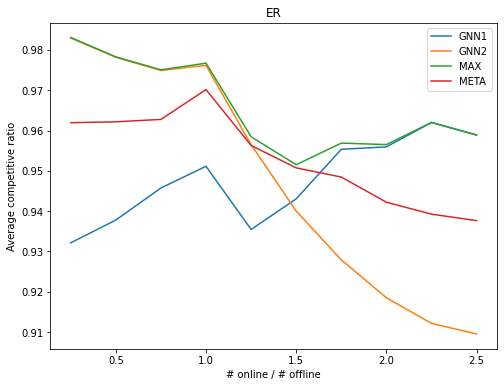

BA


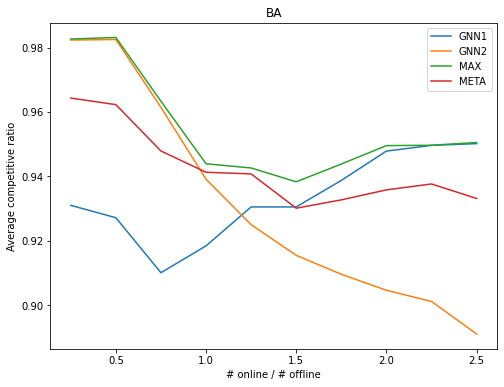

GEOM


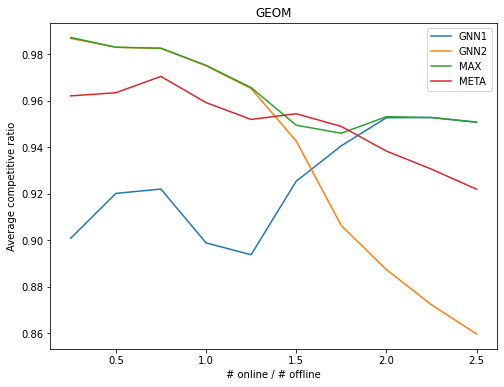

In [21]:
import matplotlib.pyplot as plt
ratios = [x/y for (x,y) in node_configs]
for graph_type, comp_ratios in data.items():
    greedy_avg_ratios = []
    meta_avg_ratios = []
    gnn1_avg_ratios = []
    gnn2_avg_ratios = []
    gnn3_avg_ratios = []
    max_avg_ratios = []

    for trial_ratios in comp_ratios:
        meta_avg_ratios.append(np.array(trial_ratios[0]).mean())
        gnn1_avg_ratios.append(np.array(trial_ratios[1]).mean())
        gnn2_avg_ratios.append(np.array(trial_ratios[2]).mean())
        #gnn3_avg_ratios.append(np.array(trial_ratios[3]).mean())
        greedy_avg_ratios.append(np.array(trial_ratios[3]).mean())
        max_avg_ratios.append(np.array(np.max(trial_ratios[1:3, :], axis=0)).mean())

    print(graph_type)
    fig = plt.figure(figsize=(8,6))
    plt.title(graph_type)
    plt.plot(ratios, gnn1_avg_ratios, label='GNN1')
    plt.plot(ratios, gnn2_avg_ratios, label='GNN2')
    #plt.plot(ratios, gnn3_avg_ratios, label='GNN3')
    #plt.plot(ratios, greedy_avg_ratios, label='Greedy')
    plt.plot(ratios, max_avg_ratios, label='MAX')
    plt.plot(ratios, meta_avg_ratios, label='META')
    plt.xlabel('# online / # offline')
    plt.ylabel('Average competitive ratio')
    plt.legend()
    plt.show()


In [ ]:
comp = np.vstack([gnn1_learned_ratios, gnn2_learned_ratios, greedy_ratios]).T
comp[:10]

In [ ]:
print(np.max(comp[:2, :], axis=1).mean())
print(comp.mean(axis=0))

In [ ]:
index1 = np.argmax(comp[:, 0] - comp[:, 1])
index2 = np.argmax(comp[:, 1] - comp[:, 0])

In [ ]:
tc._featurize(instances[index1])

In [ ]:
tc._featurize(instances[index2])

In [ ]:
GNN2_features = []
GNN1_features = []
for i, boolean in enumerate(comp[:, 1] > comp[:, 0]):
    if boolean:
        GNN2_features.append(tc._featurize(instances[i]))
    else:
        GNN1_features.append(tc._featurize(instances[i]))

out1 = np.vstack(GNN1_features)
out2 = np.vstack(GNN2_features)


In [ ]:
out1.mean(axis=0)

In [ ]:
out2.mean(axis=0)